In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns 

from itertools import product

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

In [3]:
class ETL:
    def __init__(self):
        self.common_data_path = '../input/competitive-data-science-predict-future-sales'

        self.sales_train = None
        self.shops = None
        self.test = None
        self.item_categories = None
        self.items = None

    def extract(self) -> None:
        self.sales_train = pd.read_csv(f'{self.common_data_path}/sales_train.csv')
        self.shops = pd.read_csv(f'{self.common_data_path}/shops.csv')
        self.test = pd.read_csv(f'{self.common_data_path}/test.csv')
        self.item_categories = pd.read_csv(f'{self.common_data_path}/item_categories.csv')
        self.items = pd.read_csv(f'{self.common_data_path}/items.csv')

    def transform(self) -> None:
        self.sales_train.date = pd.to_datetime(self.sales_train.date)
        self.sales_train['month'] = self.sales_train.date.dt.to_period('M')

        self.sales_train = self.sales_train[self.sales_train.item_cnt_day > -2]
        self.sales_train = self.sales_train[self.sales_train.item_price < 300_000]
        self.sales_train = self.sales_train[self.sales_train.month < '2015-11']

        id_of_duplicated_shops = {10: 11, 0: 57, 1: 58, 40: 39}

        for k, v in id_of_duplicated_shops.items():
            self.shops = self.shops[self.shops.shop_id != k]
            self.sales_train.loc[self.sales_train.shop_id == k, 'shop_id'] = v

        self.test.loc[self.test.shop_id == 10, 'shop_id'] = 11

        self.shops.shop_name = self.shops.shop_name.map(lambda x: x.lstrip('!'))

        self.shops['city'] = self.shops.shop_name.str.split(' ').map(lambda x: x[0])
        self.shops['category'] = self.shops.shop_name.str.split(' ').map(lambda x: x[1])

        shop_enc = LabelEncoder()
        self.shops['shop_category'] = shop_enc.fit_transform(self.shops['category'])
        shop_city_enc = LabelEncoder()
        self.shops['shop_city'] = shop_city_enc.fit_transform(self.shops['city'])
        self.shops = self.shops[['shop_id', 'shop_category', 'shop_city']]

        self.sales_train = self.sales_train.drop_duplicates(
            subset=['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'],
            keep='last')

        self.items.item_name = self.items.item_name.map(lambda x: x.lstrip('!*/'))

        same_items_regardless_case = self.items[self.items.item_name.map(lambda x: x.lower()).duplicated()]
        fully_same = self.items.groupby(self.items.item_name, as_index=False).size().query('size > 1')
        fully_same_item_names = fully_same.item_name.values

        self.items = self.items[self.items.item_id != 12]
        self.sales_train = self.sales_train[self.sales_train.item_id != 12]

        same_items_regardless_case_names = same_items_regardless_case[~same_items_regardless_case.item_name.isin(
            fully_same_item_names)].item_name

        same_items = self.items[self.items.item_name.map(lambda x: x.lower()).isin(
            same_items_regardless_case_names.map(lambda x: x.lower()))]

        same_items_upper_case = same_items[same_items.item_name.str.endswith('(Регион)')]
        same_items_lower_case = same_items[same_items.item_name.str.endswith('(регион)')]

        self.items = self.items[~self.items.item_id.isin(same_items_lower_case.item_id)]

        self.sales_train.loc[self.sales_train.item_id.isin(same_items_lower_case.item_id), 'item_id'] = \
            self.sales_train[self.sales_train.item_id.isin(same_items_lower_case.item_id)].item_id.map(lambda x: x - 1)

        self.test.loc[self.test.item_id.isin(same_items_lower_case.item_id), 'item_id'] = \
            self.test[self.test.item_id.isin(same_items_lower_case.item_id)].item_id.map(lambda x: x - 1)

        self.items = self.items[self.items.item_id != 13012]
        self.sales_train.loc[self.sales_train.item_id == 13012, 'item_id'] = 13011
        self.test.loc[self.test.item_id == 13012, 'item_id'] = 13011

        self.items['name1'], self.items['name2'] = self.items['item_name'].str.split('[', 1).str
        self.items['name1'], self.items['name3'] = self.items['item_name'].str.split('(', 1).str

        self.items['name2'] = self.items['name2'].str.replace('\W+', ' ').str.lower()
        self.items['name3'] = self.items['name3'].str.replace('\W+', ' ').str.lower()

        self.items = self.items.fillna('0')

        self.items['name2'] = LabelEncoder().fit_transform(self.items['name2'])
        self.items['name3'] = LabelEncoder().fit_transform(self.items['name3'])

        self.items.drop(['item_name', 'name1'], axis=1, inplace=True)

        self.item_categories['type_code'] = self.item_categories['item_category_name'].apply(
            lambda x: x.split(' ')[0]).astype(str)

        categories = []
        for cat in self.item_categories['type_code'].unique():
            if len(self.item_categories[self.item_categories['type_code'] == cat]) > 3:
                categories.append(cat)
        self.item_categories['type_code'] = self.item_categories['type_code'].apply(
            lambda c: c if c in categories else 'other')

        self.item_categories['type_code'] = LabelEncoder().fit_transform(self.item_categories['type_code'])
        self.item_categories['subcat'] = self.item_categories['item_category_name'].apply(lambda x: x.split('-')).apply(
            lambda x: x[1].strip() if len(x) >= 2 else x[0].strip())

        self.item_categories['subcat'] = LabelEncoder().fit_transform(self.item_categories['subcat'])
        self.item_categories.drop('item_category_name', axis=1, inplace=True)

    def load(self):
        
        return self.sales_train, self.shops, self.test, self.item_categories, self.items

In [4]:
etl = ETL()
etl.extract()
etl.transform()

sales, shops, test, item_categories, items = etl.load()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:82: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:83: FutureWarning: The default value of regex will change from True to False in a future version.


In [5]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()

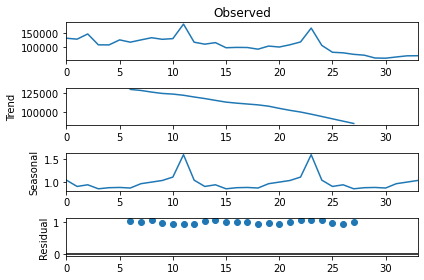

In [6]:
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="multiplicative")
fig = res.plot()

In [7]:
class RollingWindowCV(object):
    
    def __init__(self, train_period=6, test_period=1, gap=1):
        self.train_period = train_period
        self.test_period = test_period
        self.gap = gap

        
    def split(self, data, date_column='date_block_num'):

        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []
        
        start_train = int(data[date_column].min())
        end_train = start_train + self.train_period
        start_test = end_train + self.gap
        end_test = start_test + self.test_period

        while end_test < data[date_column].max():
            cur_train_indices = list(data[(data[date_column] >= start_train) & 
                                     (data[date_column] < end_train)].index)


            cur_test_indices = list(data[(data[date_column] >= start_test) &
                                    (data[date_column] < end_test)].index)
            
            print("Train period:", start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)


            start_train = end_train + 1
            end_train = start_train + self.train_period
            start_test = end_train + self.gap
            end_test = start_test + self.test_period
        
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        return self.n_splits 

In [8]:
train = []
cols  = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales_train = sales[sales['date_block_num'] == i]
    train.append(
        np.array(
            list(product(
                [i],
                sales_train['shop_id'].unique(),
                sales_train['item_id'].unique()
            )),
            dtype = np.int16
        )
    )

train = pd.DataFrame(np.vstack(train), columns=cols)
train = train.astype({
    'date_block_num': np.int8, 
    'shop_id': np.int8, 
    'item_id': np.int16
})
train.sort_values(cols, inplace=True)

In [9]:
sales['total_sales'] = sales['item_cnt_day'] * sales['item_price']

In [10]:
item_cnt_month = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'item_cnt_day': 'sum'})

item_cnt_month.columns = ['item_cnt_month']
item_cnt_month.reset_index(inplace=True)

train = pd.merge(train, item_cnt_month, on=cols, how='left')
train['item_cnt_month'] = train['item_cnt_month'].fillna(0).astype(np.float16)

In [11]:
test = test[['shop_id', 'item_id']]

In [12]:
test['date_block_num'] = 34

In [13]:
train = pd.concat([train, test],ignore_index=True, sort=False, keys=cols)
train.fillna(0, inplace=True)

In [14]:
train = pd.merge(train, items, on='item_id', how='left')
train = pd.merge(train, item_categories, on='item_category_id', how='left')
train = pd.merge(train, shops, on='shop_id', how='left')

In [15]:
def add_lags(df, periods, cols):
    for col in cols:
        temp = df[['date_block_num', 'shop_id', 'item_id', col]]
        for per in periods:
            shifted = temp.copy()
            shifted.columns = ['date_block_num', 'shop_id', 'item_id', col + "_lag_" + str(per)]
            shifted['date_block_num'] = shifted['date_block_num'] + per
            df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

In [16]:
train = add_lags(train, [1, 12], ['item_cnt_month'])

In [17]:
train

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,name2,name3,type_code,subcat,shop_category,shop_city,item_cnt_month_lag_1,item_cnt_month_lag_12
0,0,2,19,0.0,40,4,42,5,4,9,0,NaN,NaN
1,0,2,27,1.0,19,77,42,3,10,9,0,NaN,NaN
2,0,2,28,0.0,30,108,42,3,55,9,0,NaN,NaN
3,0,2,29,0.0,23,124,42,3,16,9,0,NaN,NaN
4,0,2,32,0.0,40,4,42,5,4,9,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10996327,34,45,18454,0.0,55,4,42,7,2,9,20,1.0,NaN
10996328,34,45,16188,0.0,64,4,42,8,42,9,20,0.0,NaN
10996329,34,45,15757,0.0,55,4,42,7,2,9,20,0.0,0.0
10996330,34,45,19648,0.0,40,4,1367,5,4,9,20,0.0,NaN


In [26]:
tscv = RollingWindowCV()
models = []
for train_index, test_index in tscv.split(train, date_column='date_block_num'):
    train_sub = train.loc[train_index]
    valid_sub = train.loc[test_index]
    
    X_train = train_sub.drop(['item_cnt_month'], axis=1)
    y_train = train_sub['item_cnt_month']
    
    X_valid = valid_sub.drop(['item_cnt_month'], axis=1)
    y_valid = valid_sub['item_cnt_month']
    
    X_train = X_train.fillna(0)
    y_train = y_train.fillna(0)
    
    X_valid = X_valid.fillna(0)
    y_valid = y_valid.fillna(0)
    
    y_train = y_train.clip(0, 30)
    y_valid = y_valid.clip(0, 30)
    
    model = XGBRegressor(
       max_depth=5,
       n_estimators=1000,
       min_child_weight=0.8, 
       colsample_bytree=0.8, 
       subsample=0.8, 
       eta=0.1,
       used_ram_limit= "13gb",
    )

    model.fit(
       X_train, 
       y_train, 
       eval_metric='rmse',
       eval_set=[(X_train, y_train), (X_valid, y_valid)], 
       verbose=True, 
       early_stopping_rounds=10
    )
    
    error = np.sqrt(mean_squared_error(y_valid, model.predict(X_valid), squared=False))
    
    models.append((error, model))

Train period: 0 - 6 , Test period 7 - 8 # train records 2260882 , # test records 361170
Train period: 7 - 13 , Test period 14 - 15 # train records 2186175 , # test records 334311
Train period: 14 - 20 , Test period 21 - 22 # train records 1936366 , # test records 321963
Train period: 21 - 27 , Test period 28 - 29 # train records 1804844 , # test records 228888


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[09:27:32] WARNING: ../src/learner.cc:627: 
Parameters: { "used_ram_limit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:1.36163	validation_1-rmse:1.32296
[1]	validation_0-rmse:1.32694	validation_1-rmse:1.28262
[2]	validation_0-rmse:1.29763	validation_1-rmse:1.24950
[3]	validation_0-rmse:1.27357	validation_1-rmse:1.22048
[4]	validation_0-rmse:1.26630	validation_1-rmse:1.21430
[5]	validation_0-rmse:1.26129	validation_1-rmse:1.21024
[6]	validation_0-rmse:1.24264	validation_1-rmse:1.18738
[7]	validation_0-rmse:1.22744	validation_1-rmse:1.16918
[8]	validation_0-rmse:1.22413	validation_1-rmse:1.16625
[9]	validation_0-rmse:1.22099	validation_1-rmse:1.16357
[10]	validation_0-rmse:1.20917	validation_1-rmse:1.14799
[11]	validation_0-

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[09:29:09] WARNING: ../src/learner.cc:627: 
Parameters: { "used_ram_limit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:1.51538	validation_1-rmse:1.40827
[1]	validation_0-rmse:1.46325	validation_1-rmse:1.36282
[2]	validation_0-rmse:1.41877	validation_1-rmse:1.32988
[3]	validation_0-rmse:1.38157	validation_1-rmse:1.30164
[4]	validation_0-rmse:1.35054	validation_1-rmse:1.27838
[5]	validation_0-rmse:1.34321	validation_1-rmse:1.26942
[6]	validation_0-rmse:1.31805	validation_1-rmse:1.25018
[7]	validation_0-rmse:1.30936	validation_1-rmse:1.24251
[8]	validation_0-rmse:1.28954	validation_1-rmse:1.22822
[9]	validation_0-rmse:1.28273	validation_1-rmse:1.22564
[10]	validation_0-rmse:1.26675	validation_1-rmse:1.21195
[11]	validation_0-

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[09:30:06] WARNING: ../src/learner.cc:627: 
Parameters: { "used_ram_limit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:1.27268	validation_1-rmse:1.46556
[1]	validation_0-rmse:1.22661	validation_1-rmse:1.41506
[2]	validation_0-rmse:1.18782	validation_1-rmse:1.37593
[3]	validation_0-rmse:1.15510	validation_1-rmse:1.34545
[4]	validation_0-rmse:1.12776	validation_1-rmse:1.31880
[5]	validation_0-rmse:1.10502	validation_1-rmse:1.29667
[6]	validation_0-rmse:1.09692	validation_1-rmse:1.29013
[7]	validation_0-rmse:1.09171	validation_1-rmse:1.28496
[8]	validation_0-rmse:1.07445	validation_1-rmse:1.27060
[9]	validation_0-rmse:1.05995	validation_1-rmse:1.25840
[10]	validation_0-rmse:1.04804	validation_1-rmse:1.24920
[11]	validation_0-

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[09:30:39] WARNING: ../src/learner.cc:627: 
Parameters: { "used_ram_limit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:1.44904	validation_1-rmse:1.23806
[1]	validation_0-rmse:1.39837	validation_1-rmse:1.19914
[2]	validation_0-rmse:1.35382	validation_1-rmse:1.16918
[3]	validation_0-rmse:1.31707	validation_1-rmse:1.14516
[4]	validation_0-rmse:1.30307	validation_1-rmse:1.13536
[5]	validation_0-rmse:1.27360	validation_1-rmse:1.11685
[6]	validation_0-rmse:1.24871	validation_1-rmse:1.10115
[7]	validation_0-rmse:1.22826	validation_1-rmse:1.08801
[8]	validation_0-rmse:1.21039	validation_1-rmse:1.07955
[9]	validation_0-rmse:1.19613	validation_1-rmse:1.07219
[10]	validation_0-rmse:1.19070	validation_1-rmse:1.06820
[11]	validation_0-

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[09:21:28] WARNING: ../src/learner.cc:627: 
Parameters: { "used_ram_limit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:1.36163	validation_1-rmse:1.32296
[1]	validation_0-rmse:1.32694	validation_1-rmse:1.28262
[2]	validation_0-rmse:1.29763	validation_1-rmse:1.24950
[3]	validation_0-rmse:1.27357	validation_1-rmse:1.22048
[4]	validation_0-rmse:1.26630	validation_1-rmse:1.21430
[5]	validation_0-rmse:1.26129	validation_1-rmse:1.21024
[6]	validation_0-rmse:1.24264	validation_1-rmse:1.18738
[7]	validation_0-rmse:1.22744	validation_1-rmse:1.16918
[8]	validation_0-rmse:1.22413	validation_1-rmse:1.16625
[9]	validation_0-rmse:1.22099	validation_1-rmse:1.16357
[10]	validation_0-rmse:1.20917	validation_1-rmse:1.14799
[11]	validation_0-

In [37]:
final_model =  min(models, key = lambda score: score[0])[1]

In [47]:
X_test = train[train.date_block_num == 34]

In [54]:
X_test = X_test.drop('item_cnt_month', axis=1)

In [55]:
X_test = X_test.fillna(0)

In [56]:
predictions = final_model.predict(X_test)

In [69]:
submission = {'ID': test.index, 'item_cnt_month': predictions}
submission = pd.DataFrame(submission)

In [79]:
submission.to_csv('submission.csv', index=False)